# Q-learning

In [4]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

import os
import sys
sys.path.append("../scripts")

from plotting import *
from enviroment import *

In [2]:
seeds = [
    960703545, 1277478588, 1936856304, 186872697, 1859168769, 1598189534, 1822174485, 1871883252, 694388766,
    188312339, 773370613, 2125204119, 2041095833, 1384311643, 1000004583, 358485174, 1695858027, 762772169,
    437720306, 939612284
]

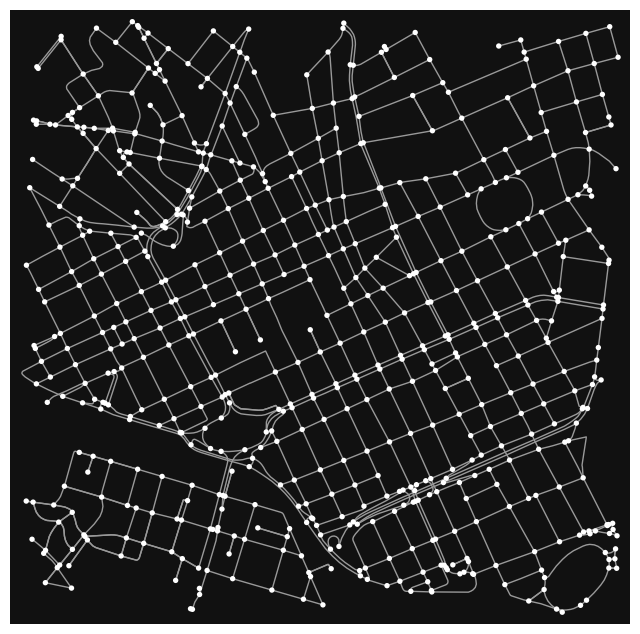

In [6]:
G = ox.graph_from_address('Campinas, São Paulo', network_type='drive')
G = nx.convert_node_labels_to_integers(G)
ox.plot_graph(G)
source = 507
target = 235

In [5]:
class QLAgent:
    def __init__(
        self, 
        env, 
        learning_rate = 0.7, 
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        tol = 1e-6,
        seed = None
    ):
        self.env = env
        self.n_states = env.get_n_states()
        self.set_Q()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.tol = tol
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

    def set_Q(self):
        self.Q = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            for action in range(self.n_states):
                if state == action:
                    self.Q[state, action] = 0
                else:
                    try:
                        self.env.G[state][action][0]["length"]
                        self.Q[state, action] = 0
                    except:
                        self.Q[state, action] = -np.inf
                
    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        return np.random.choice(np.where(self.Q[state, :] == np.max(self.Q[state, :]))[0])
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.env.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            # update Q table based on Bellman equation
            self.Q[state, action] += self.learning_rate * (
                reward
                + self.gamma * np.max(self.Q[new_state, :])
                - self.Q[state, action]
            )
            state = new_state
            route.append(state)

            if done:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in range(self.n_episodes):
            self.generate_episode(self.epsilon)
            self.update_epsilon()
            
        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
          

    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost

## Parameters experiments

In [7]:
def experiment_handler(seeds, env, fixed_agent_params, testing_agent_param):
    testing_agent_param_name = testing_agent_param[0]
    testing_agent_param_values = testing_agent_param[1]
    results = []
    env.reset()
    for value in tqdm(testing_agent_param_values):
        fixed_agent_params[testing_agent_param_name] = value
        for i, seed in enumerate(seeds):
            start = time()
            agent = QLAgent(
                env = env,
                seed = seed,
                **fixed_agent_params,
            )
            agent.train()
            end = time()
            route, cost = agent.route_to_target(G, env.source, env.target)
            results.append(
                {"seed" : seed,
                 testing_agent_param_name : value,
                 "cost" : cost,
                 "time" : end - start,
                 "rewards" : agent.episode_rewards,
                }
            )
            env.reset()

    return results

In [24]:
env = Environment(G, source, target, "unit", "deterministic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/unit_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/unit_deterministic_lr.json")
env = Environment(G, source, target, "weighted", "deterministic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/weighted_deterministic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/weighted_deterministic_lr.json")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [03:16<00:00, 39.33s/it]


In [28]:
env = Environment(G, source, target, "unit", "stochastic")
fixed_agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
}
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/unit_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/unit_stochastic_lr.json")
env = Environment(G, source, target, "weighted", "stochastic")
results_gamma = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["gamma", [0.1, 0.25, 0.5, 0.9, 0.99]]
)
pd.DataFrame(results_gamma).to_json("results/weighted_stochastic_gamma.json")
results_lr = experiment_handler(
    seeds,
    env,
    fixed_agent_params,
    ["learning_rate", [0.05, 0.1, 0.3, 0.5, 0.7]]
)
pd.DataFrame(results_lr).to_json("results/weighted_stochastic_lr.json")

100%|██████████| 5/5 [04:03<00:00, 48.79s/it]


In [9]:

def analysis_results(reward_method, env_method):
    results_lr = pd.read_json(f"results/{reward_method}_{env_method}_lr.json")
    results_gamma = pd.read_json(f"results/{reward_method}_{env_method}_gamma.json")
    results_lr["rewards"] = results_lr.rewards.apply(np.mean)
    results_gamma["rewards"] = results_gamma.rewards.apply(np.mean)

    results_lr = results_lr.groupby("learning_rate").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_lr.columns = ["_".join(col) for col in results_lr.columns]
    results_lr = results_lr.reset_index()

    results_gamma = results_gamma.groupby("gamma").agg({
        "cost" : ["mean", "std"],
        "time" : ["mean", "std"],
        "rewards" : ["mean", "std"]
    })
    results_gamma.columns = ["_".join(col) for col in results_gamma.columns]
    results_gamma = results_gamma.reset_index()
    plot_results_experiments(results_lr, results_gamma, f"{reward_method} reward and {env_method} environment")

def plot_results_experiments(results_lr, results_gamma, title):
    """Plot the results of the experiments varying learning rate and gamma.

    Parameters
    ----------
    results_lr : pd.DataFrame
        Dataframe with columns learning_rate, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    results_gamma : pd.DataFrame
        Dataframe with columns gamma, cost_mean, cost_std, time_mean, time_std, rewards_mean, rewards_std
    title : str 
        Title of the plot
    """
    def plot_line_plot_err(df, param, cost, ax):
        ax.plot(df[param], df[f"{cost}_mean"], color = "black")
        ax.fill_between(
            df[param],
            df[f"{cost}_mean"] - df[f"{cost}_std"],
            df[f"{cost}_mean"] + df[f"{cost}_std"],
            color = "black",
            alpha = 0.2
        )
        ax.set_xlabel(param)
        ax.set_ylabel(cost)
        ax.set_title(f"{cost} by {param}")
        ax.grid()

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
    axs = axs.flatten()

    plot_line_plot_err(results_lr, "learning_rate", "cost", axs[0])
    plot_line_plot_err(results_lr, "learning_rate", "time", axs[1])
    plot_line_plot_err(results_lr, "learning_rate", "rewards", axs[2])

    plot_line_plot_err(results_gamma, "gamma", "cost", axs[3])
    plot_line_plot_err(results_gamma, "gamma", "time", axs[4])
    plot_line_plot_err(results_gamma, "gamma", "rewards", axs[5])

    plt.suptitle(title, fontsize = 16)
    plt.show()


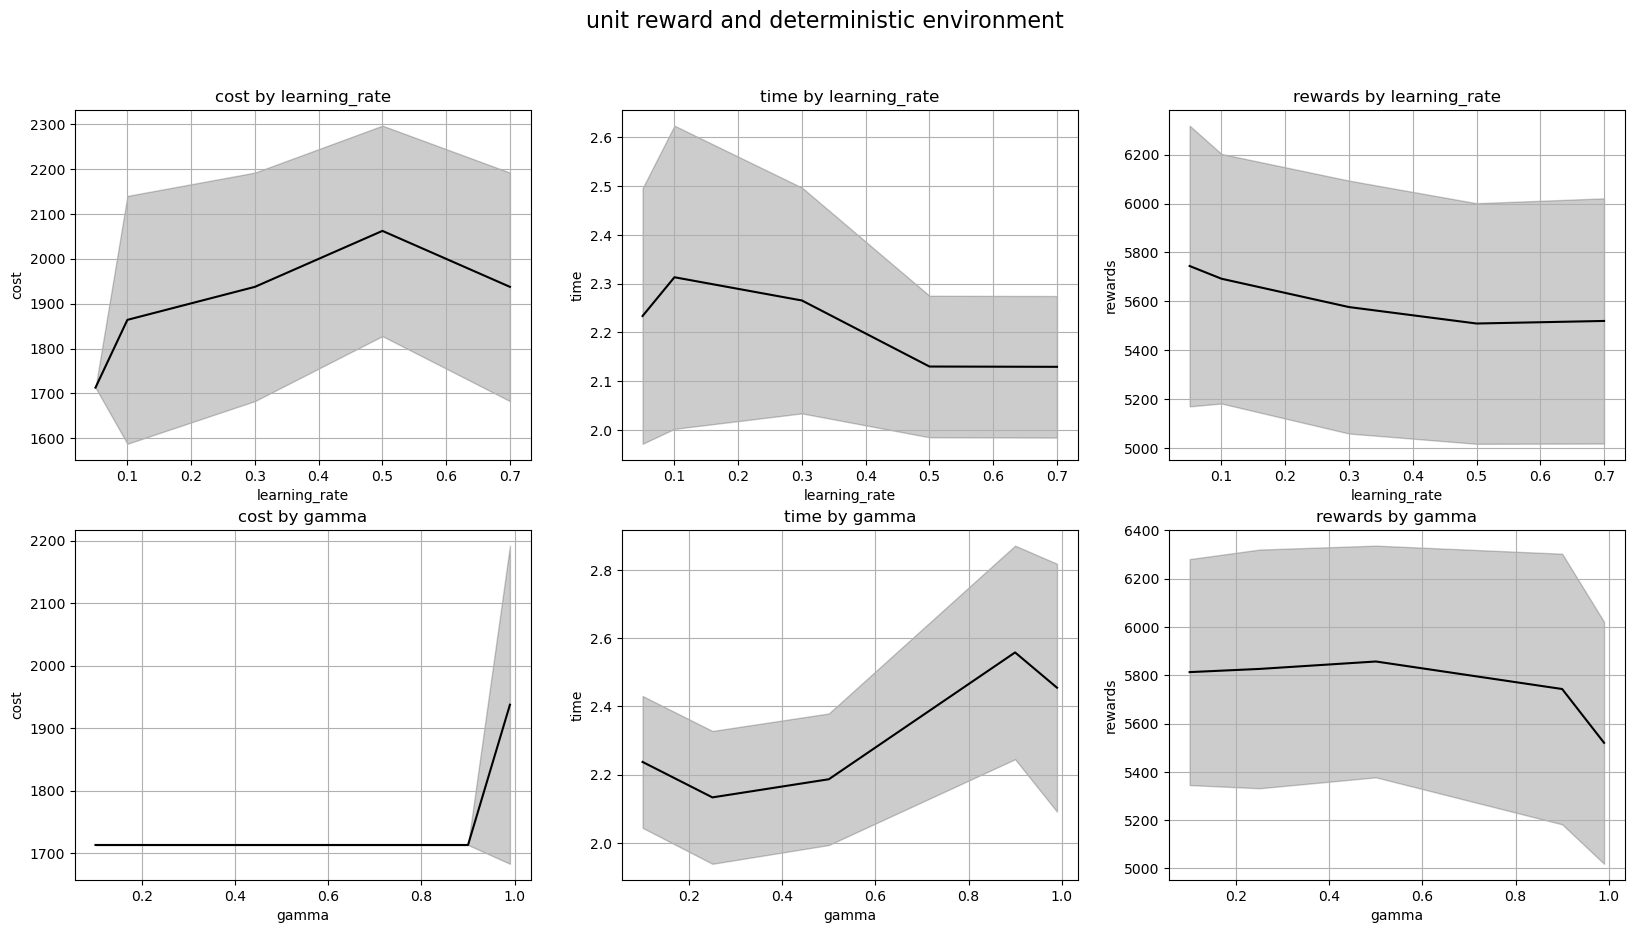

In [32]:
analysis_results("unit", "deterministic")

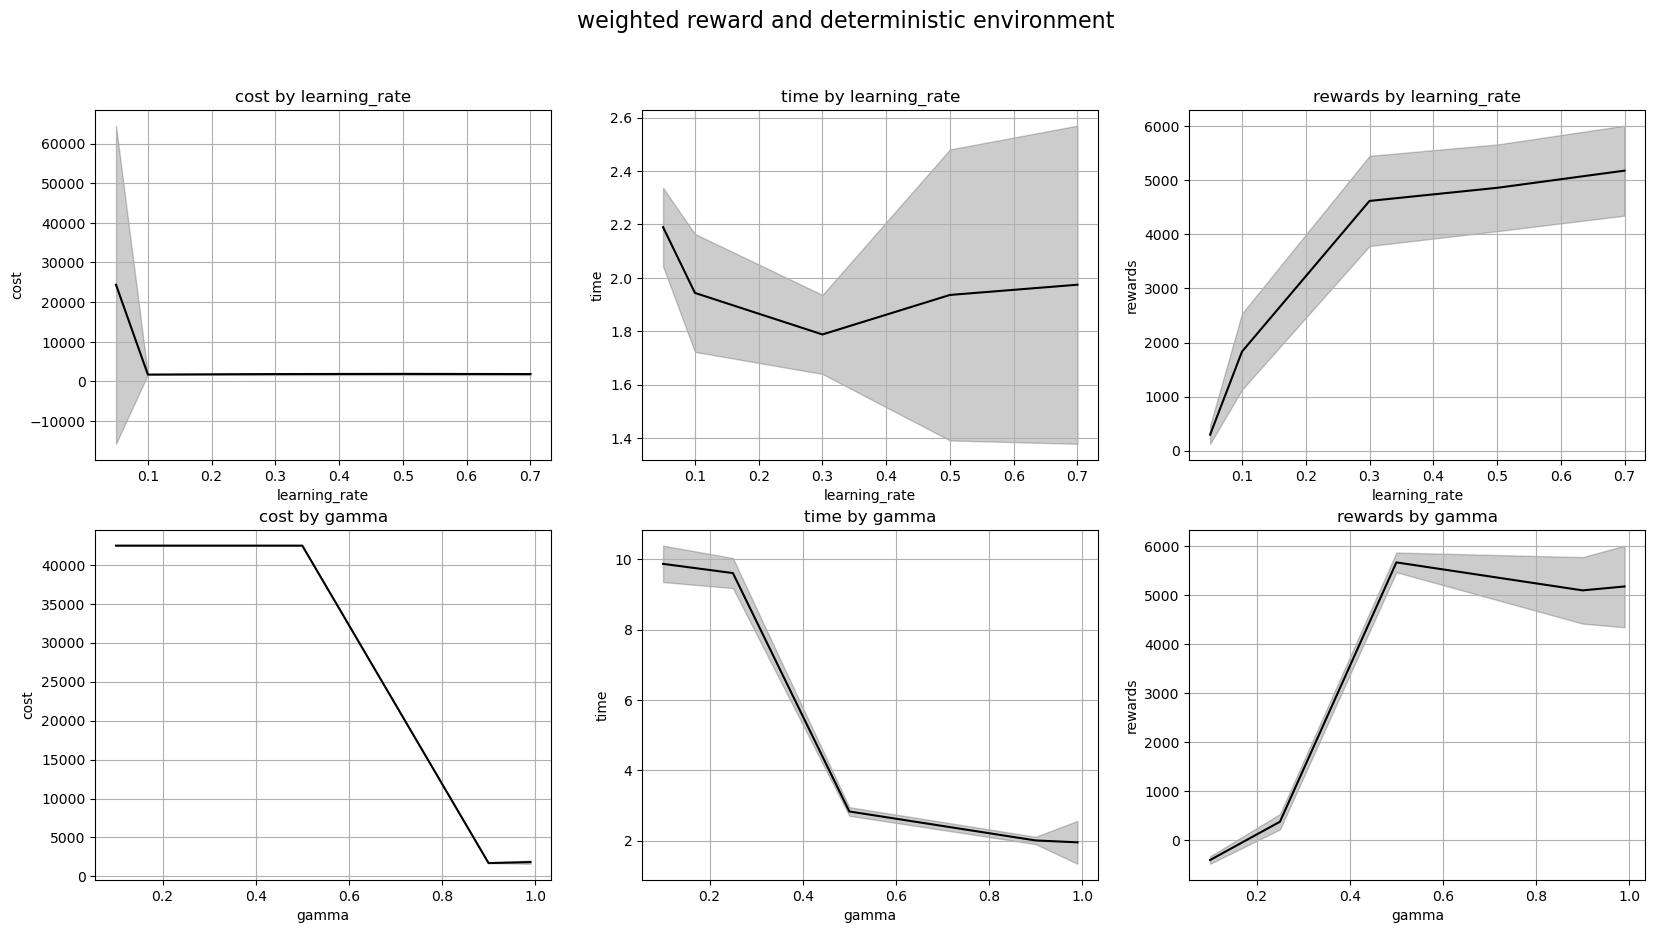

In [25]:
analysis_results("weighted", "deterministic")

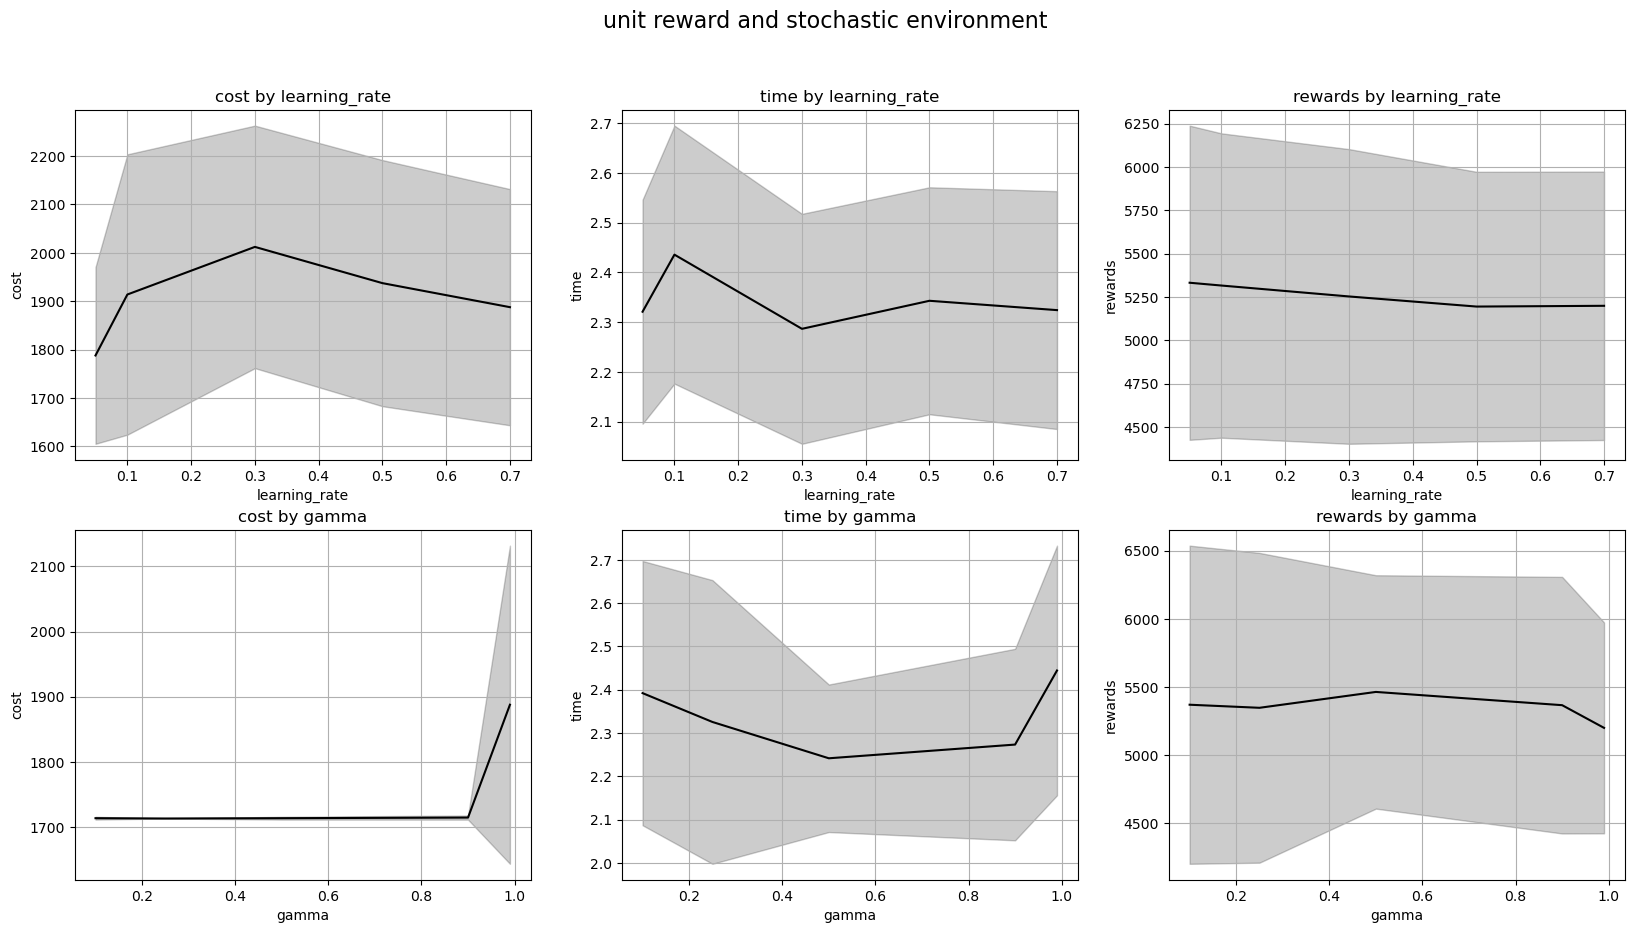

In [29]:
analysis_results("unit", "stochastic")

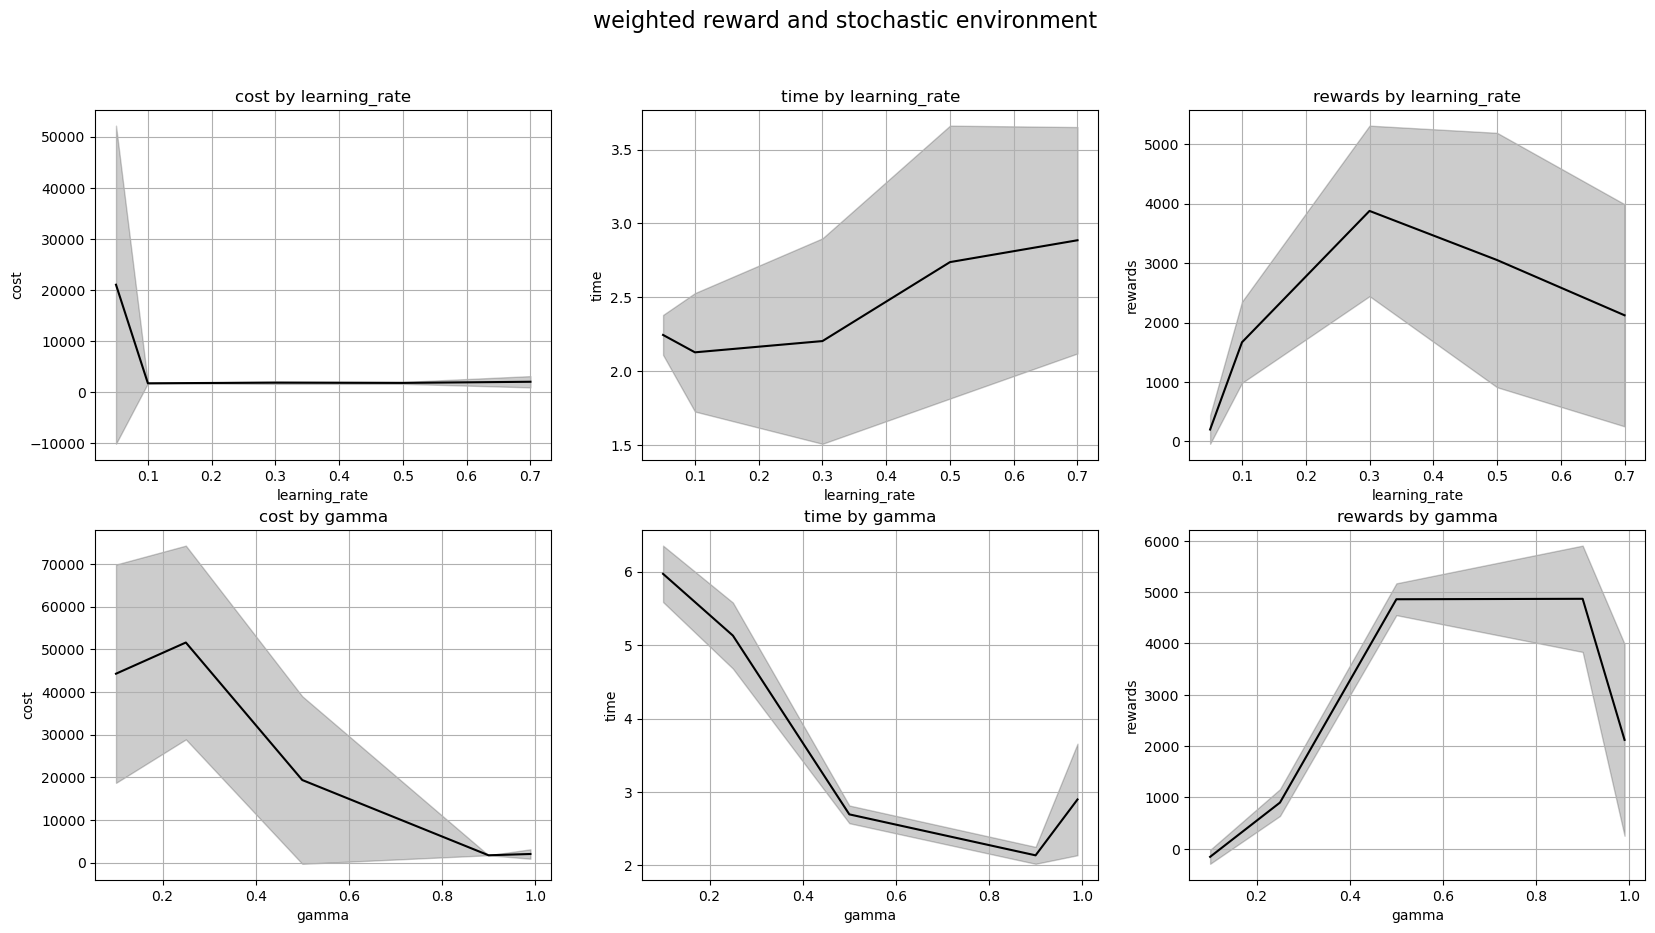

In [30]:
analysis_results("weighted", "stochastic")

## Generalization experiments

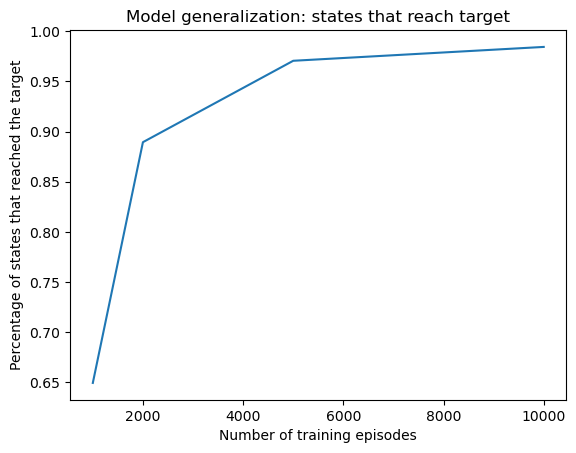

In [7]:
env = Environment(G, source, target, reward = "weighted", mode = "deterministic")
n_episodes_list = [1000, 2000, 5000, 10000]
reach_list = []
for n_episodes in n_episodes_list:
    env.reset()
    agent = QLAgent(env, learning_rate=0.3, gamma = 0.9, n_episodes=n_episodes)
    agent.train()


    n_reached = 0
    n_possible = len(G.nodes)
    for i in range(len(G.nodes)):
        _, cost = agent.route_to_target(G, i, target)
        try:
            opt_cost = nx.shortest_path_length(G, i, target, weight="length")
            if cost < np.inf:
                n_reached += 1
        except:
            n_possible -= 1
    
    reach_list.append(n_reached / n_possible)

plt.plot(n_episodes_list, reach_list)
plt.xlabel("Number of training episodes")
plt.ylabel("Percentage of states that reached the target")
plt.title("Model generalization: states that reach target")
plt.show()


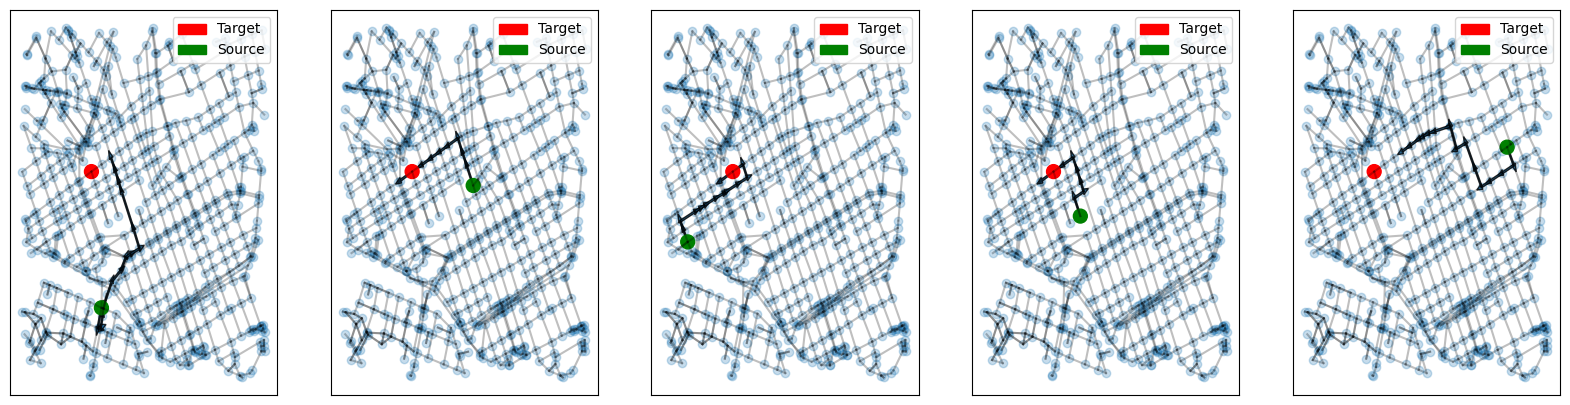

In [8]:
random_states = []

while len(random_states) < 5:
    state = np.random.choice(list(G.nodes))
    if state not in random_states and nx.has_path(G, state, target):
        random_states.append(state)

#fig, axs = plt.subplots(nrows = 1, ncols = 5)

fig = plt.figure(figsize=(20, 5))

for i, state in enumerate(random_states):
    route, cost = agent.route_to_target(G, state, target)

    steps = min(15, len(route))
    plt.subplot(1, 5, i + 1)
    plot_few_steps_policy(G, agent.policy, state, target, steps=steps)

In [10]:
def experiment_handler2(seeds, env, agent_params = {}):
    results = []
    env.reset()
    for i, seed in tqdm(enumerate(seeds)):
        np.random.seed(seed)
        source, target = np.random.choice(env.get_n_states(), size = 2)
        while not nx.has_path(G, source, target):
            source, target = np.random.choice(env.get_n_states(), size = 2)
        
        env.source = source
        env.target = target
        env.reset()

        start = time()
        agent = QLAgent(env = env, seed = seed, **agent_params)  
        agent.train()
        end = time()
        route, cost = agent.route_to_target(G, env.source, env.target)
        optim_cost = nx.shortest_path_length(G, source, target, weight="length")
        
        results.append({
            "seed" : seed,
            "source" : source,
            "target" : target,
            "cost" : cost / optim_cost,    
            "time" : end - start,
            "rewards" : agent.episode_rewards,
        })
    return results

In [51]:
agent_params = {
    "n_episodes" : 1000,
    "max_steps" : 1000,
    "learning_rate" : 0.6,
    "gamma" : 0.7,
}
for scheme in ["unit", "weighted"]:
    for simul in ["deterministic", "stochastic"]:
        env = Environment(G, 0, 1, scheme, simul)
        results_general = experiment_handler2(
            seeds,
            env,
            agent_params,
        )
        pd.DataFrame(results_general).to_json(f"results/{scheme}_{simul}_general.json")

20it [00:34,  1.74s/it]
20it [00:38,  1.94s/it]
20it [00:39,  1.99s/it]
20it [00:40,  2.00s/it]


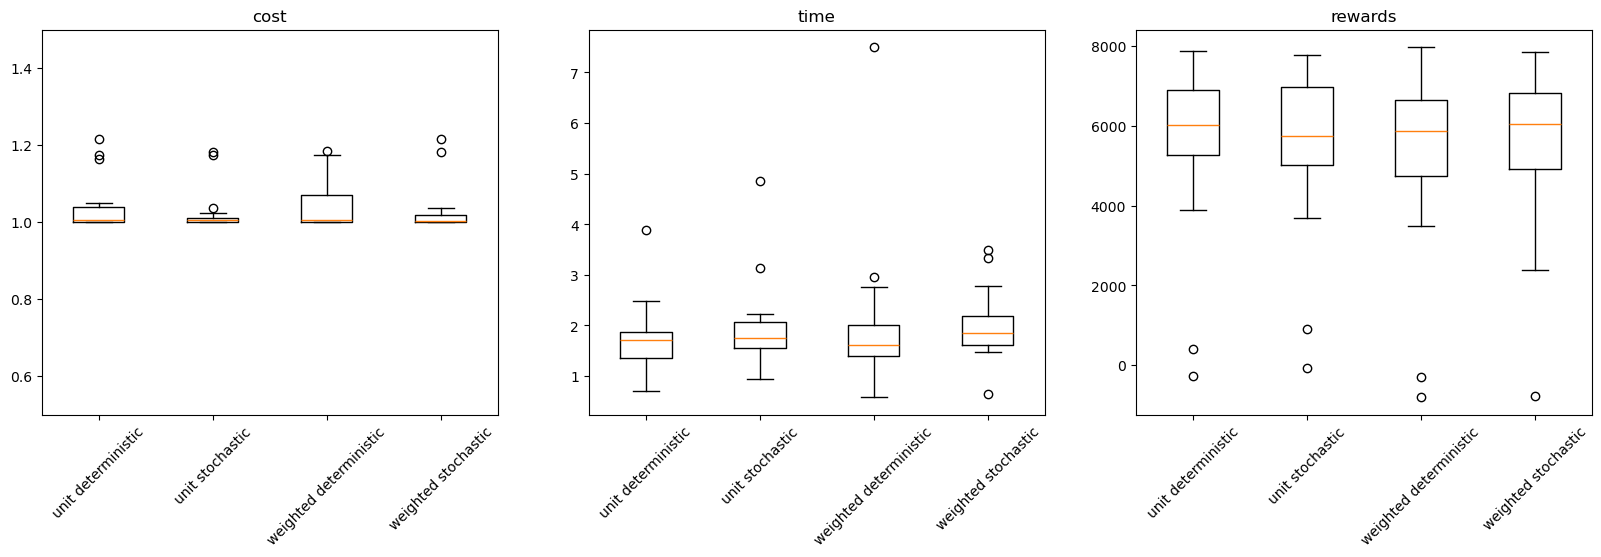

In [60]:

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 5))
for i, metric in enumerate(["cost", "time", "rewards"]):
    results_to_plot = []
    for scheme in ["unit", "weighted"]:
        for simul in ["deterministic", "stochastic"]:
            result = pd.read_json(f"results/{scheme}_{simul}_general.json")
            result["rewards"] = result["rewards"].apply(np.mean)
            results_to_plot.append(result[metric])
    axs[i].boxplot(results_to_plot)
    if i == 0:
        axs[i].set_ylim(0.5, 1.5)

    axs[i].set_xticklabels(["unit deterministic", "unit stochastic", "weighted deterministic", "weighted stochastic"], rotation = 45)
    axs[i].set_title(metric)

# Q-Learning approximation

In [9]:
class QLAgent_approx:
    def __init__(
        self, 
        env,
        G,
        learning_rate = 0.7, 
        gamma = 0.99,
        min_epsilon = 0.05,
        max_epsilon = 1,
        n_episodes = 1000,
        max_steps = 1000,
        seed = None
    ):
        self.env = env
        self.G = G
        self.n_states = env.get_n_states()
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        self.n_episodes = n_episodes
        self.max_steps = max_steps
        self.seed = seed
        if seed is not None:
            self.set_seed(seed)

        #self.features = np.zeros((self.n_states, 3))
        self.features = np.zeros((self.n_states, 2))
        for state in range(self.n_states):
            self.features[state, 0] = self.G.nodes[state]["x"]
            self.features[state, 1] = self.G.nodes[state]["y"]
            #self.features[state, 2] = len(self.G[state])
        # normalize
        self.features[:, 0] = self.features[:, 0] / np.max(self.features[:, 0])
        self.features[:, 1] = self.features[:, 1] / np.max(self.features[:, 1])
        #self.features[:, 2] = self.features[:, 2] / np.max(self.features[:, 2])
        #self.weights = np.zeros(shape = 3 * self.n_states)

        self.weights = np.zeros(shape = 4 + 2 * self.n_states)

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)

    def linear_func(self, state, action, return_feature = False):
        """For each pair of state and action, compute 6 features: 
        (x, y) coordinates of the state/action, and the number of neighbors of each one.
        Then, compute the linear combination of the features with the weights and bias.

        Parameters
        ----------
        state : int
            Index of the state
        action : int
            Index of the action

        Returns
        -------
        float
            Q value of the pair (state, action)
        """
        # features = np.zeros(3 * self.n_states)
        # features[action * 3 : action * 3 + 3] = self.features[action]
        # prediction = np.dot(self.weights, features)
        # if return_feature:
        #     return prediction, features
        # return prediction

        features = np.zeros(4 + 2 * self.n_states)
        features[state] = 1
        features[self.n_states + action] = 1
        features[-4:-2] = self.features[state]
        features[-2:] = self.features[action]
        prediction = np.dot(self.weights, features)
        if return_feature:
            return prediction, features
        return prediction
    
    def update_weights(self, reward, state, action, new_state):
        """Update the weights and bias based on the Bellman equation"""
        target = reward + self.gamma * self.argmax(new_state)
        prediction, features = self.linear_func(state, action, True)
        error = target - prediction
        for i in range(len(self.weights)):
            self.weights[i] += self.learning_rate * error * features[i]

    def argmax(self, state):
        neighbors = list(self.G.neighbors(state)) + [state]
        return np.max([self.linear_func(state, action) for action in neighbors])
    
    def greedy_policy(self, state):
        """Greedy policy that returns the action with the highest Q value"""
        neighbors = list(self.G.neighbors(state)) + [state]
        return neighbors[np.argmax([self.linear_func(state, action) for action in neighbors])]
    
    def epsilon_greedy_policy(self, state, epsilon):
        """Epsilon greedy policy that returns a random action with probability epsilon"""
        if np.random.uniform(0, 1) < epsilon:
            neighbors = list(self.G.neighbors(state))
            return np.random.choice(neighbors)
        else:
            return self.greedy_policy(state)

    def generate_episode(self, epsilon):
        state = self.env.reset()
        self.episode_rewards.append(0)
        route = [state]

        for step in range(self.max_steps):
            # Choose action and get reward
            action = self.epsilon_greedy_policy(state, epsilon)
            new_state, reward, done = self.env.step(action)
            self.episode_rewards[-1] += reward    
            
            self.update_weights(reward, state, action, new_state)
            
            state = new_state
            route.append(state)

            if done:
                break
    
    def update_epsilon(self):
        self.epsilon -= (self.max_epsilon - self.min_epsilon) / self.n_episodes
    
    def train(self):
        self.epsilon = self.max_epsilon
        self.episode_rewards = []
        for episode in tqdm(range(self.n_episodes)):
            self.generate_episode(self.epsilon)
            self.update_epsilon()
            
        self.policy = {i : self.greedy_policy(i) for i in range(self.n_states)}
          

    def route_to_target(self, G, source, target):
        route = [source]
        state = source
        cost = 0
        k = 0
        while state != target and k < 1000:
            new_state = self.policy[state]
            if new_state == state:
                cost = np.inf
                route.append(new_state)
                break
            cost += G[state][new_state][0]["length"]
            state = new_state
            route.append(state)
            k += 1
        return route, cost

In [14]:
env = Environment(G, source, target, "weighted", "deterministic")
agent = QLAgent_approx(env, G, learning_rate=0.2, gamma = 0.95, n_episodes=5000)
agent.train()

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [02:59<00:00, 27.79it/s] 


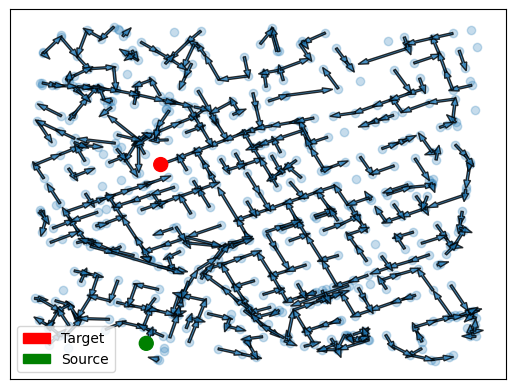

In [15]:
plot_all_paths_policy(G, agent.policy, source, target)

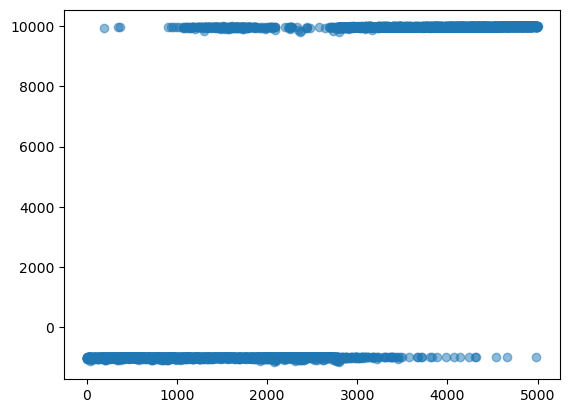

In [16]:
plt.scatter(list(range(5000)), agent.episode_rewards, alpha = 0.5)

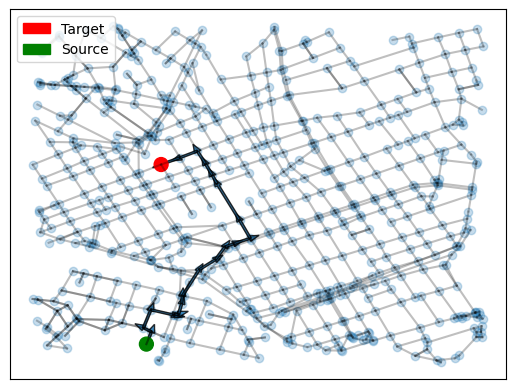

In [19]:
plot_few_steps_policy(G, agent.policy, source, target, steps = 20)